In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import sys
from pathlib import Path
module_folder = os.path.abspath('../gridsaliency-original')
if module_folder not in sys.path:
    sys.path.append(module_folder)
from mnist_generators_simple import gen_texture_mnist, plot_samples
scr_folder = os.path.abspath('../scr')
if scr_folder not in sys.path:
    sys.path.insert(1, scr_folder)
from dataloaders import Cityscapes
#from metrics import iou_coef, dice_coef, dice_loss
from unet import csbd_unet, manual_unet, TrainUnet
from training_write import TrainingParameters, TrainingResults
from training_plots import plot_predict_and_gt, plot_loss, plot_metric
from seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
import matplotlib.pyplot as plt
from visualize_sgc import SegGradCAMplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#Path to the dataset
#path = "C:\\Users\\vinograd\\Documents\\GitHub\\Seg-Grad-CAM\\inputs\\cityscapes\\leftImg8bit_trainvaltest\\leftImg8bit"
#path = "../../inputs/cityscapes/leftImg8bit_trainvaltest/leftImg8bit"
BATCH_SIZE = 4
trainparam = TrainingParameters(
epochs = 50,
    scale = 4,
    batch_size = BATCH_SIZE, 
n_train= 10, #2975 max
n_val = 30 # 500 max #"""
,steps_per_epoch = 10 #int(3000/BATCH_SIZE) #1400
    ,validation_steps = 10 # int(500/BATCH_SIZE)
    
    )
#trainparam.saveToJson()

#trainset = Cityscapes(n = trainparam.n_train, shuffle = True, scale = trainparam.scale, prefix = "train",normalize=True)
valset = Cityscapes(n = trainparam.n_val, shuffle = False, scale = trainparam.scale, prefix = "val",normalize=True)
#trainset.get_and_save_npz(path)
#valset.get_and_save_npz(path)
#trainset.load_npz()
valset.load_npz()

In [4]:
import segmentation_models as sm

BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = trainparam.n_classes  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

BATCH_SIZE = 4
LR = 0.00045
EPOCHS = 150

mdir = '../../output/unet_backbone_16_07/'
model.load_weights(mdir+'best_model.h5')

Segmentation Models: using `keras` framework.


IndexError: index 10 is out of bounds for axis 0 with size 10

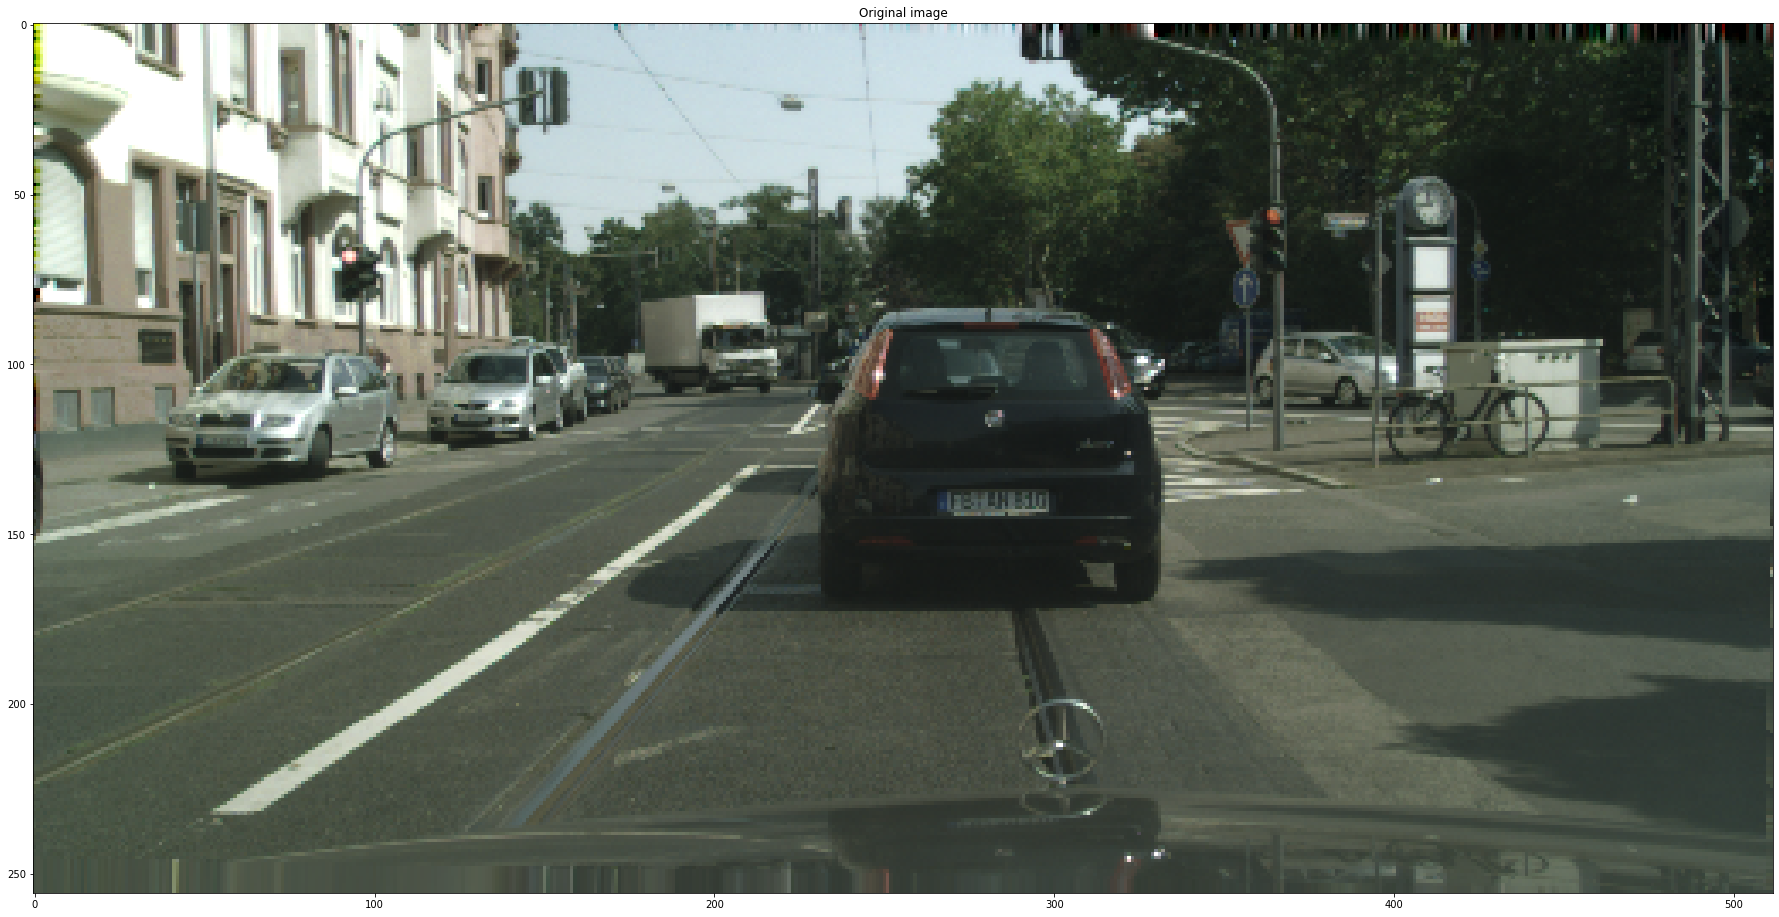

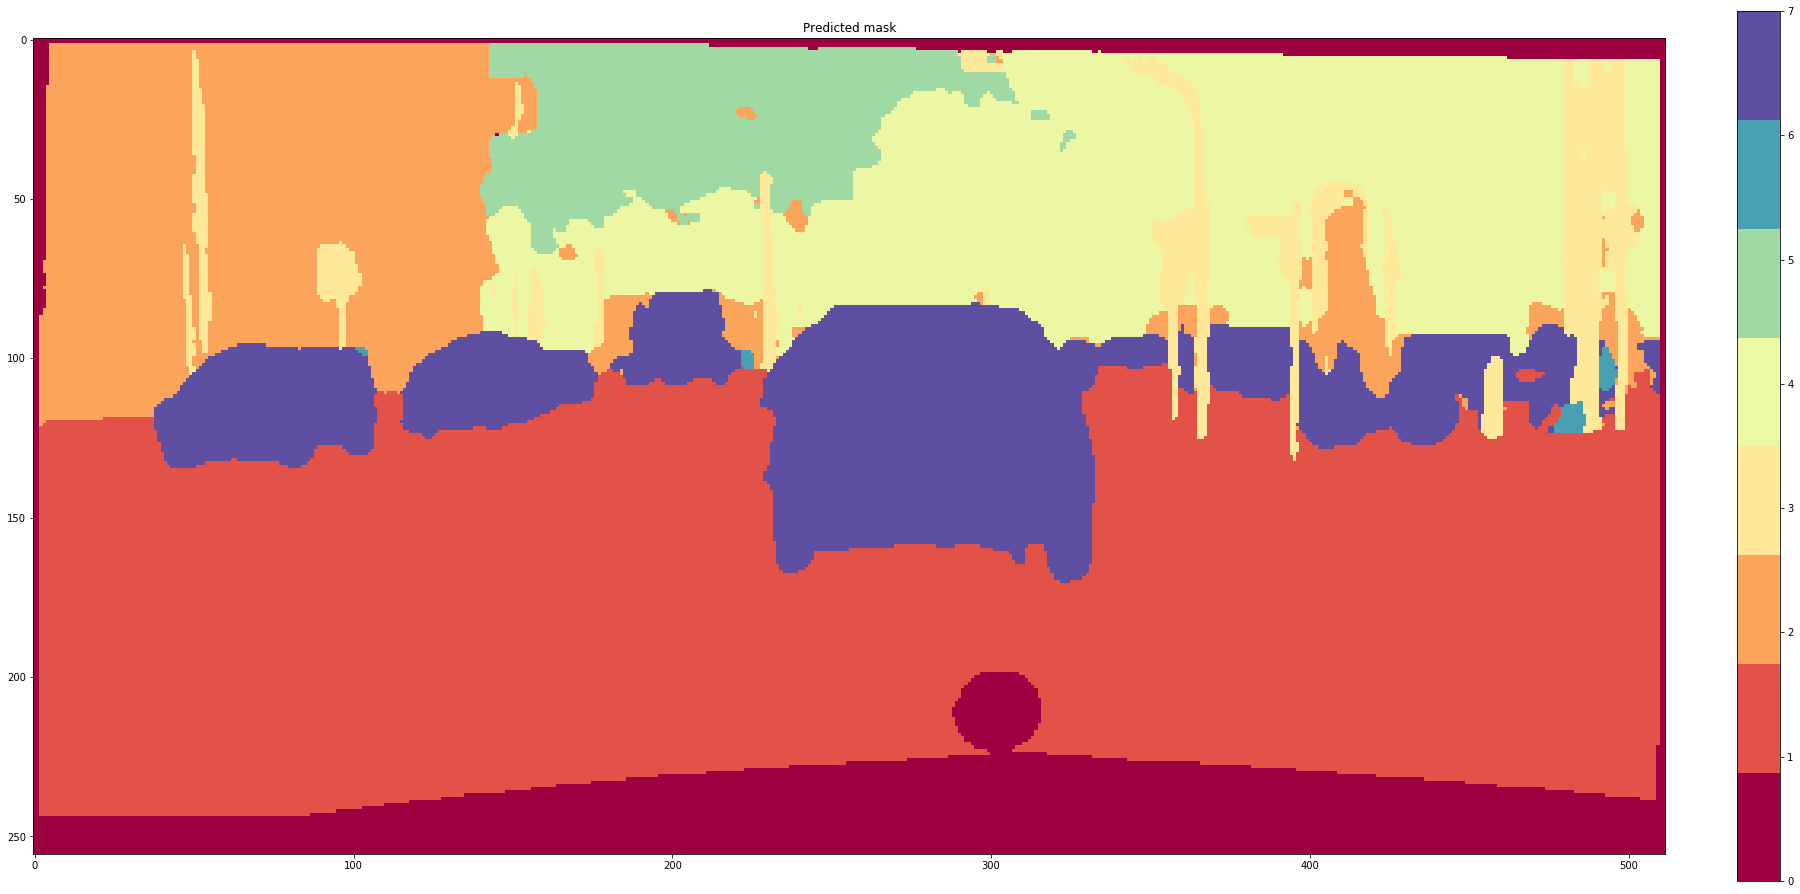

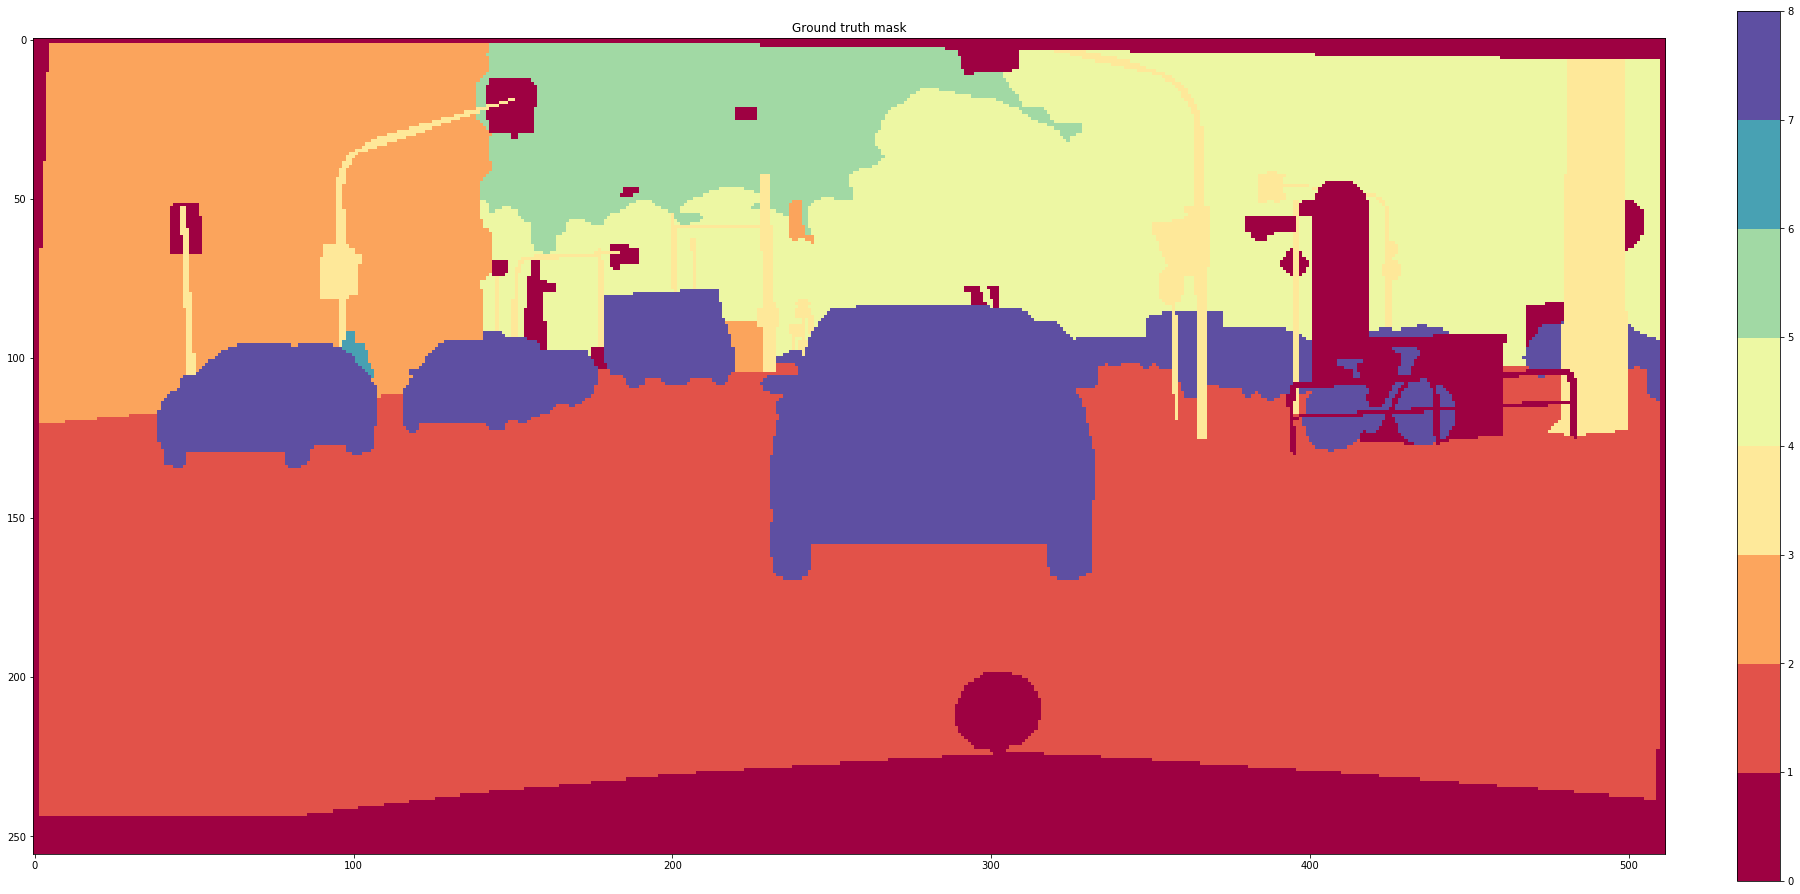

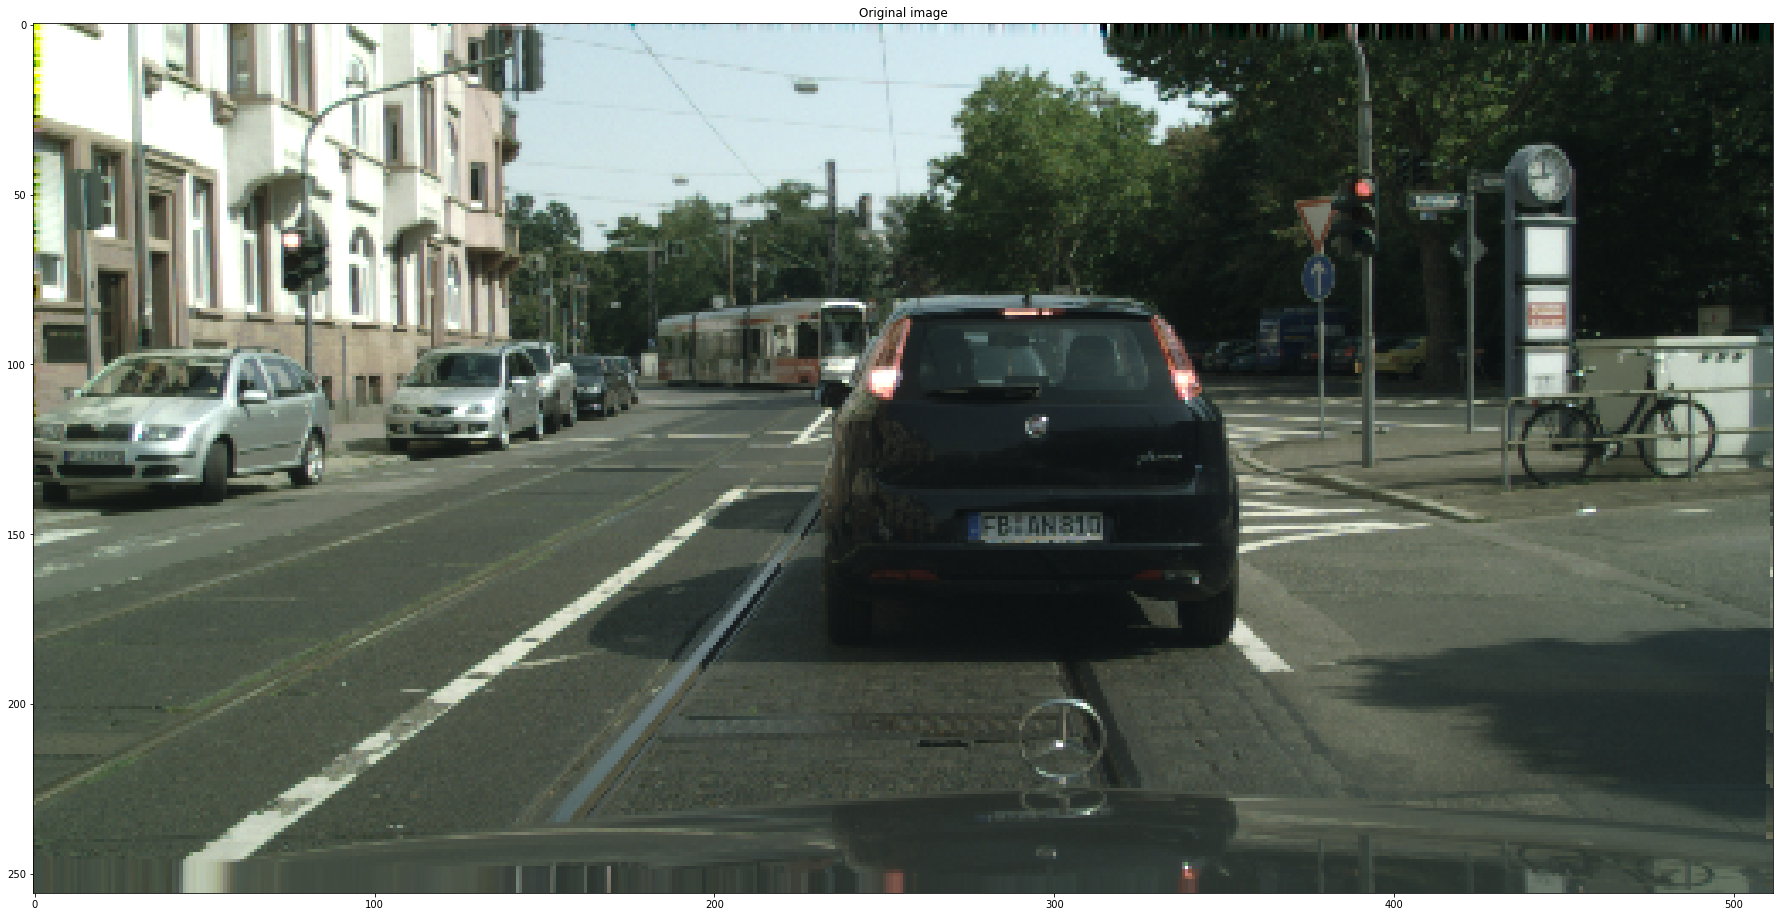

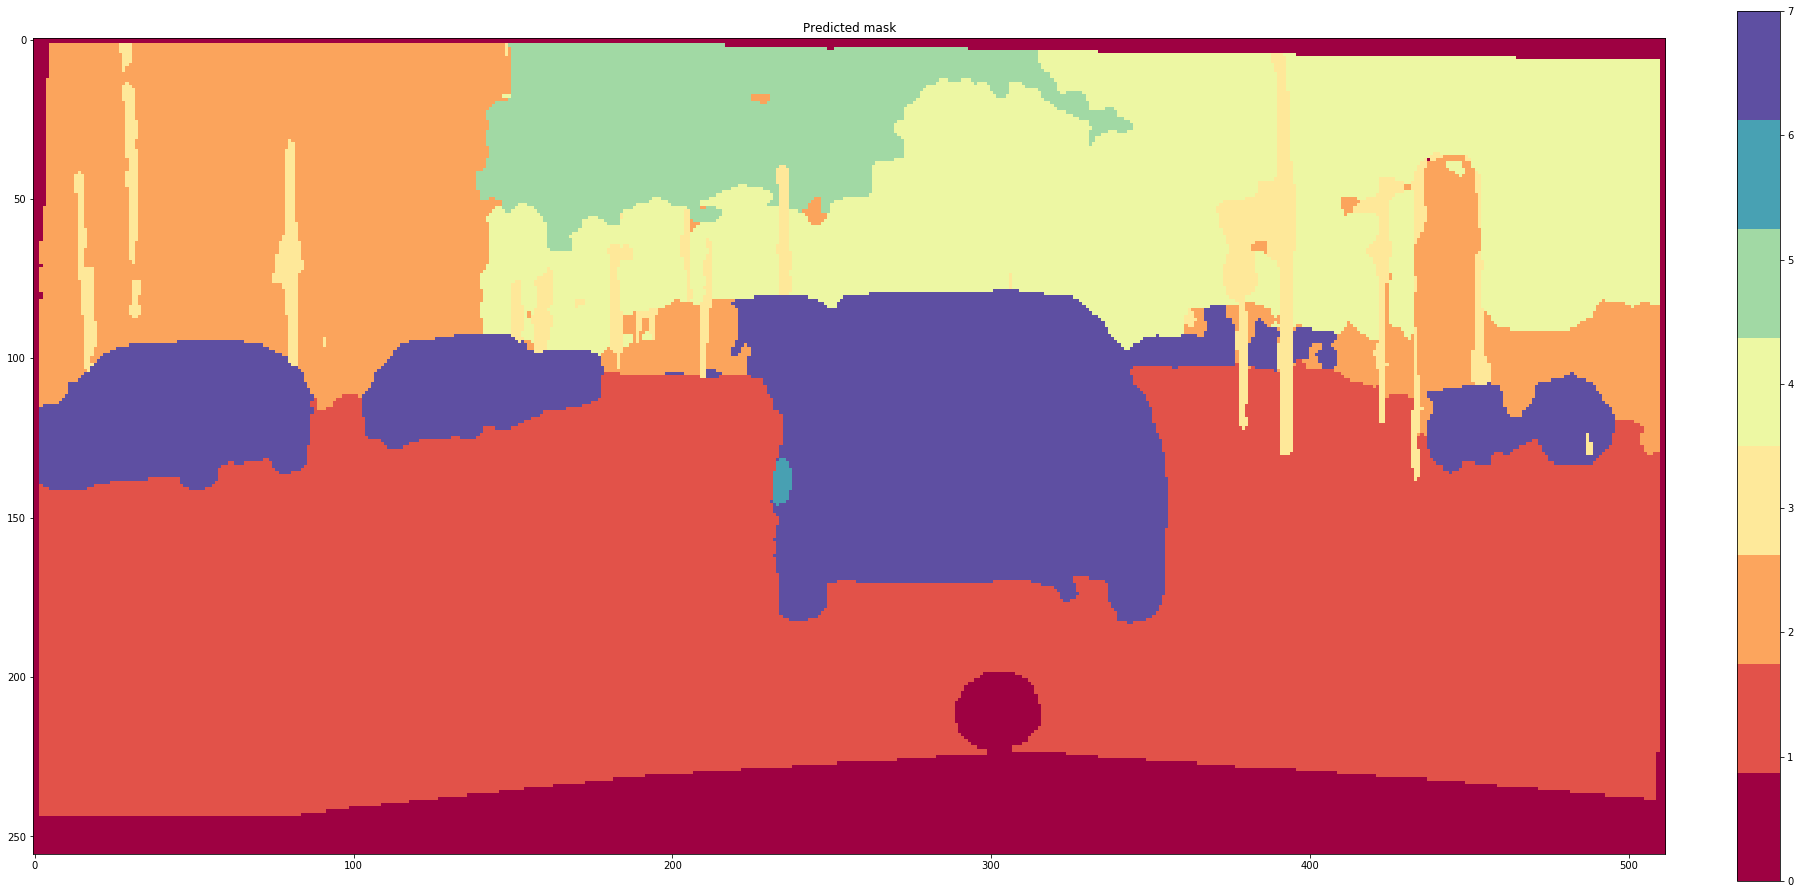

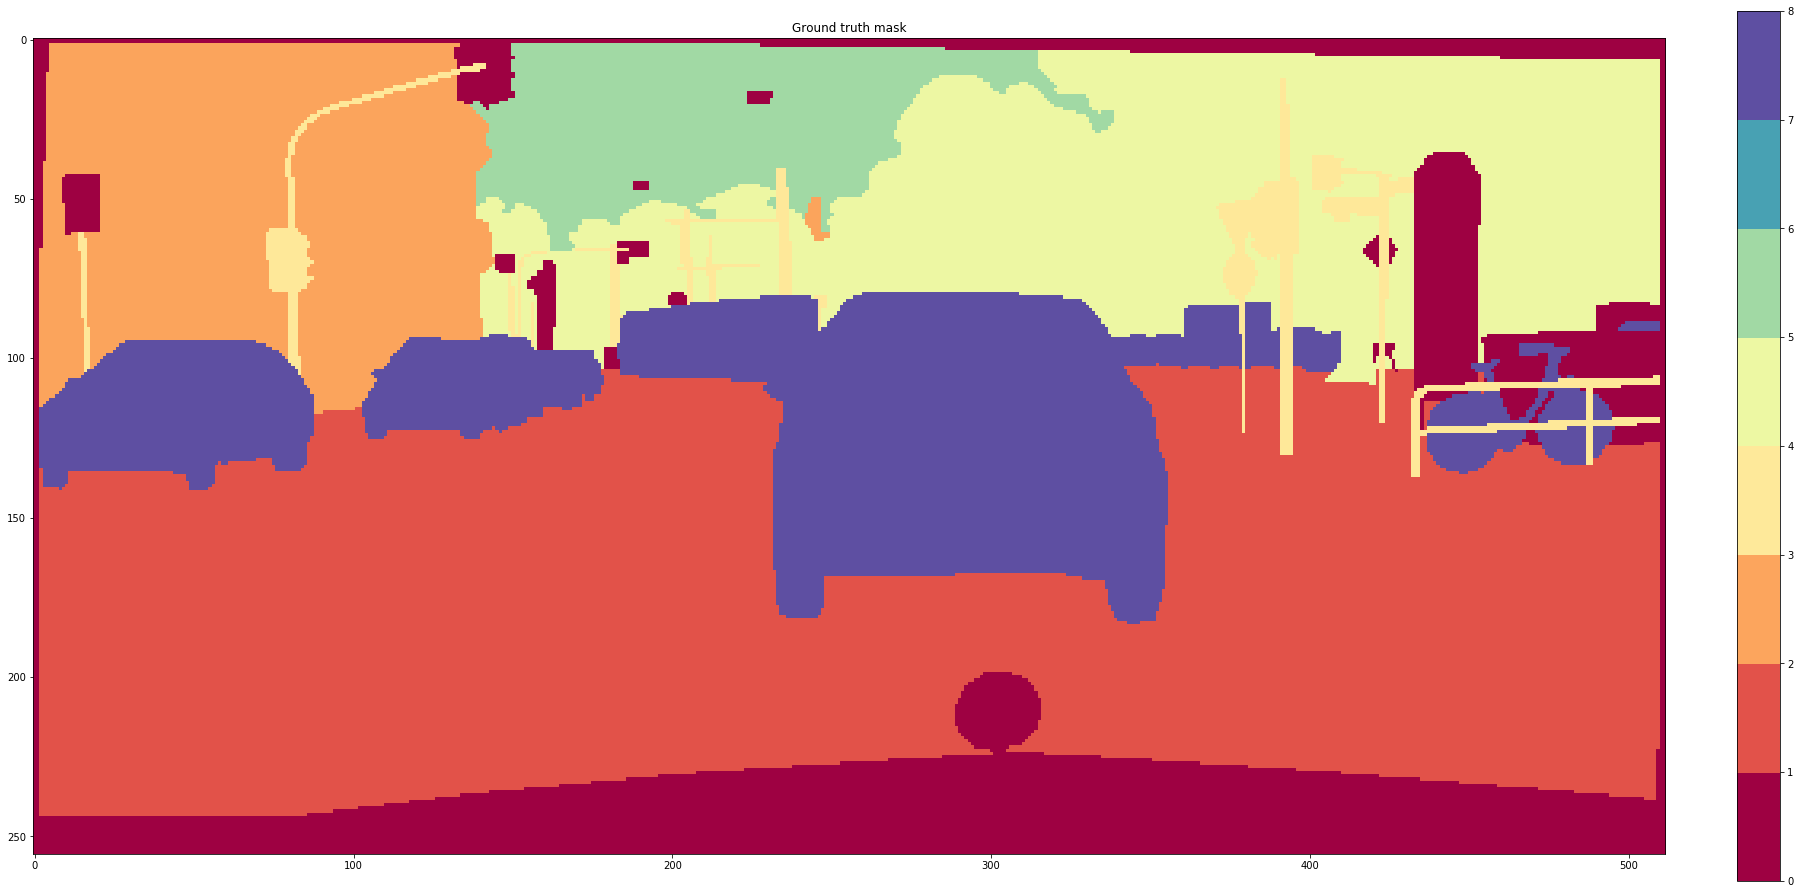

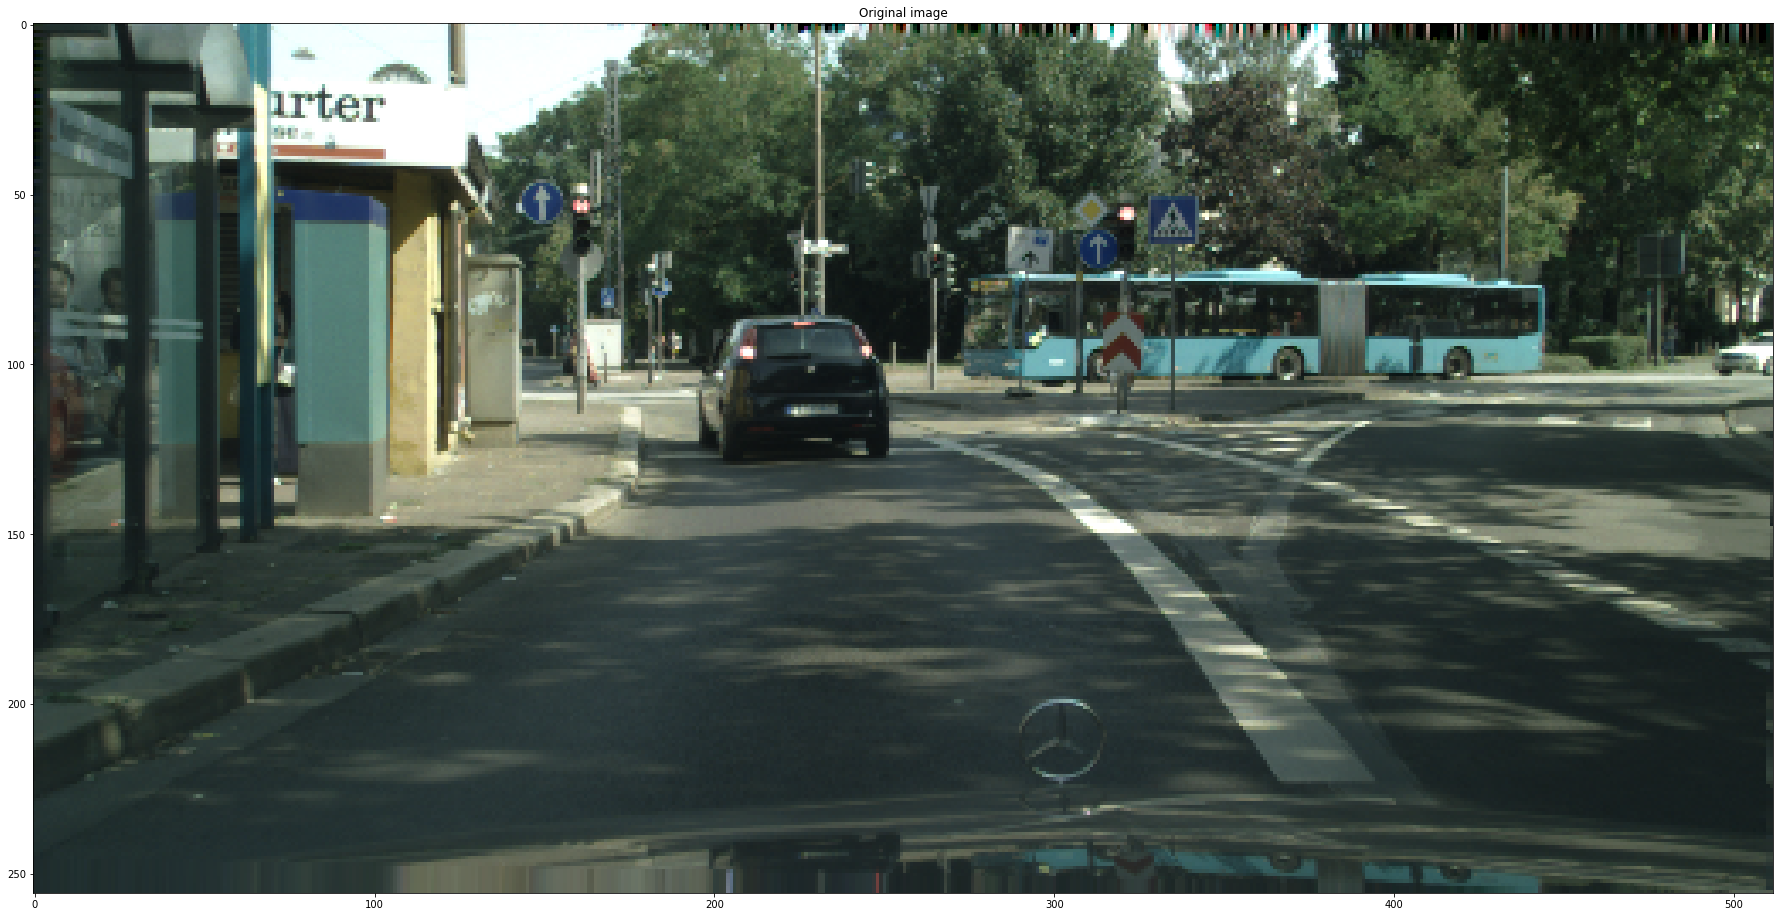

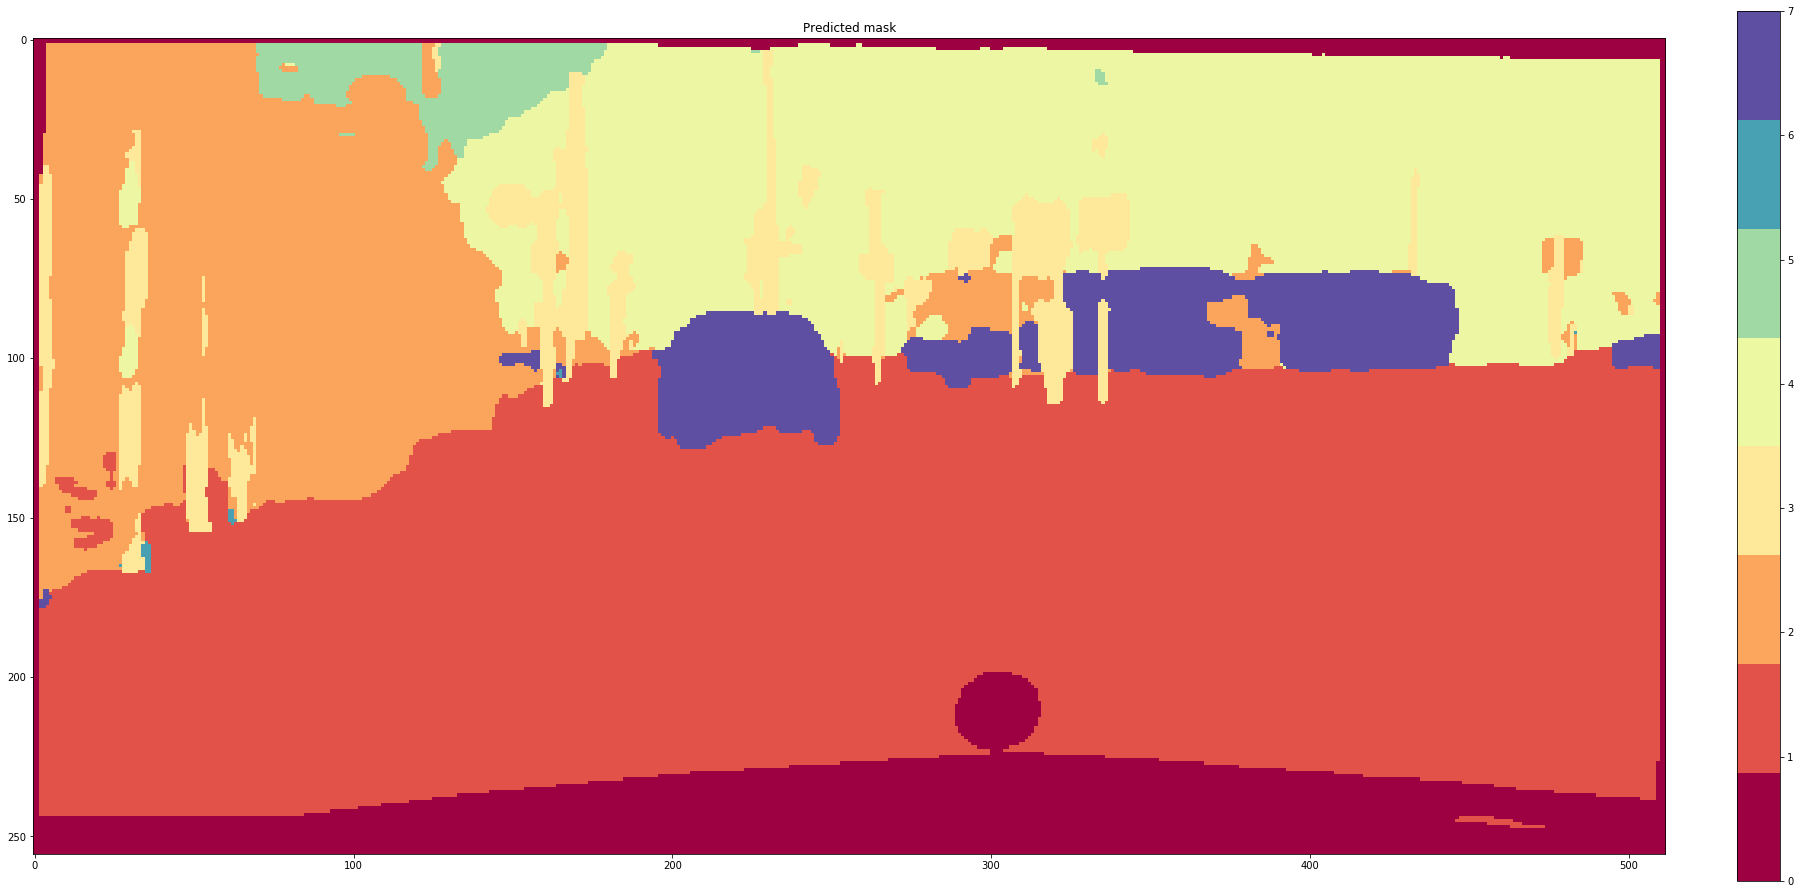

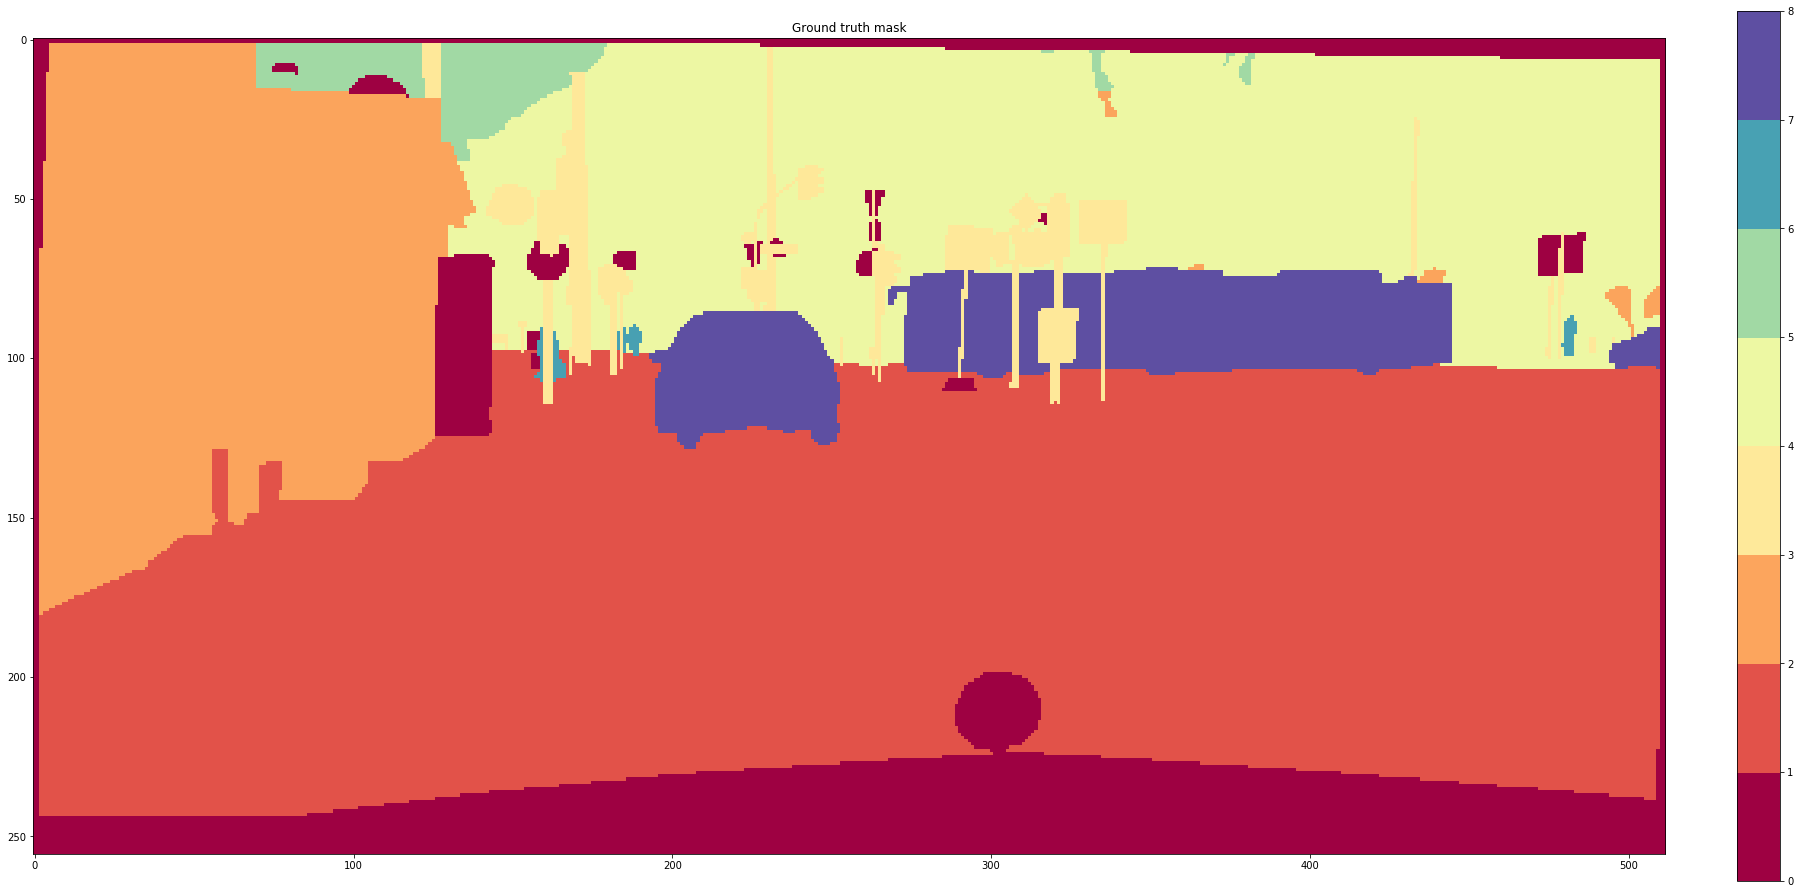

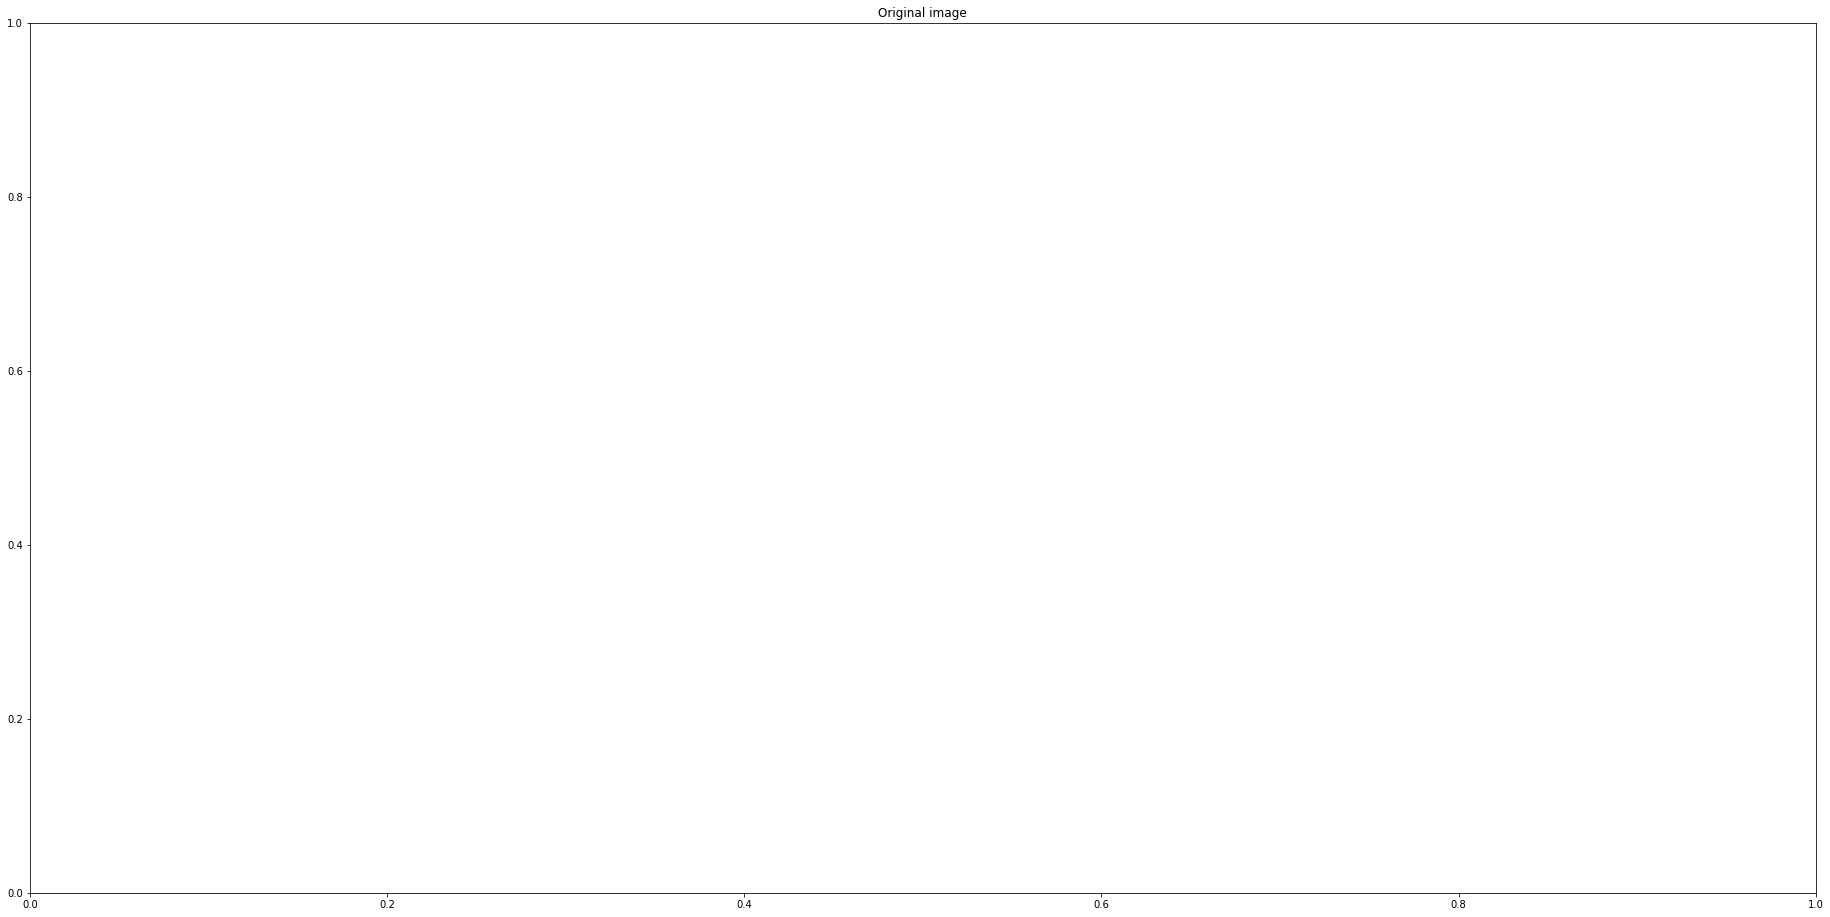

In [36]:
plot_predict_and_gt(model, valset.X, valset.Y, range(7,17,1), mdir, n_classes)

In [7]:
model.layers[-1].name

'softmax'

In [15]:
for i in range(len(model.layers)):
    print(model.layers[i].name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
center_block1_conv
center_block1_bn
center_block1_relu
center_block2_conv
center_block2_bn
center_block2_relu
decoder_stage0_upsampling
decoder_stage0_concat
decoder_stage0a_conv
decoder_stage0a_bn
decoder_stage0a_relu
decoder_stage0b_conv
decoder_stage0b_bn
decoder_stage0b_relu
decoder_stage1_upsampling
decoder_stage1_concat
decoder_stage1a_conv
decoder_stage1a_bn
decoder_stage1a_relu
decoder_stage1b_conv
decoder_stage1b_bn
decoder_stage1b_relu
decoder_stage2_upsampling
decoder_stage2_concat
decoder_stage2a_conv
decoder_stage2a_bn
decoder_stage2a_relu
decoder_stage2b_conv
decoder_stage2b_bn
decoder_stage2b_relu
decoder_stage3_upsampling
decoder_stage3_concat
decoder_stage3a_conv
decoder_stage3a_bn
decoder_stage3a_relu
decoder_stage3b_conv
decoder_stage

In [21]:
prop_from_layer = model.layers[-1].name
prop_to_layer = 'center_block1_relu'
cls = 7
imid = 3
image =  valset.X[imid]
clsroi = ClassRoI(model=model,image=image,cls=cls)

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 18684 18684


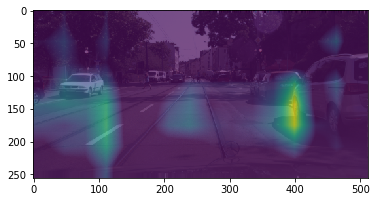

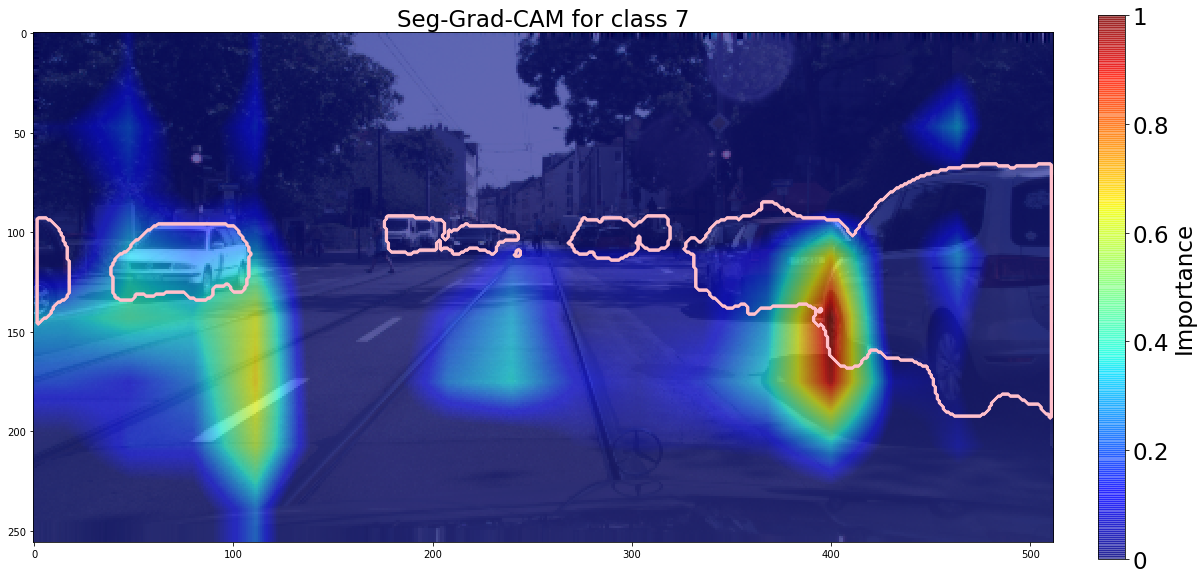

In [22]:
newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainClass()

connectedComponents values, counts:  [0 1 2 3 4 5 6] [112388  14267    831    797    651   2131      7]
argmax:  1
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 14267 14267


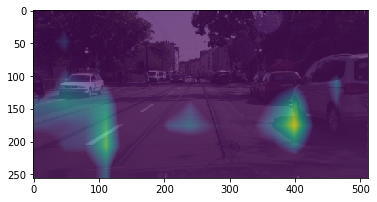

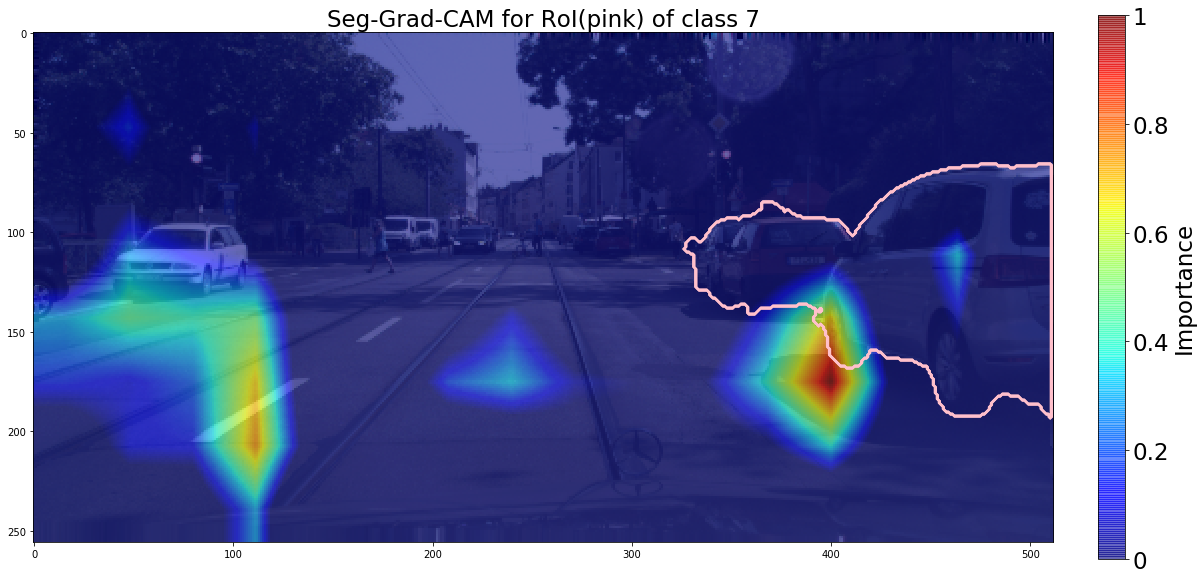

In [24]:
clsroi.largestComponent()
newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainRoi()

In [28]:
prop_from_layer = model.layers[-1].name
prop_to_layer = 'center_block2_relu'
cls = 7
imid = 3
image =  valset.X[imid]
clsroi = ClassRoI(model=model,image=image,cls=cls)

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 18684 18684


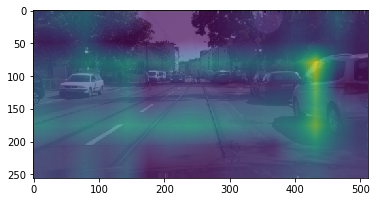

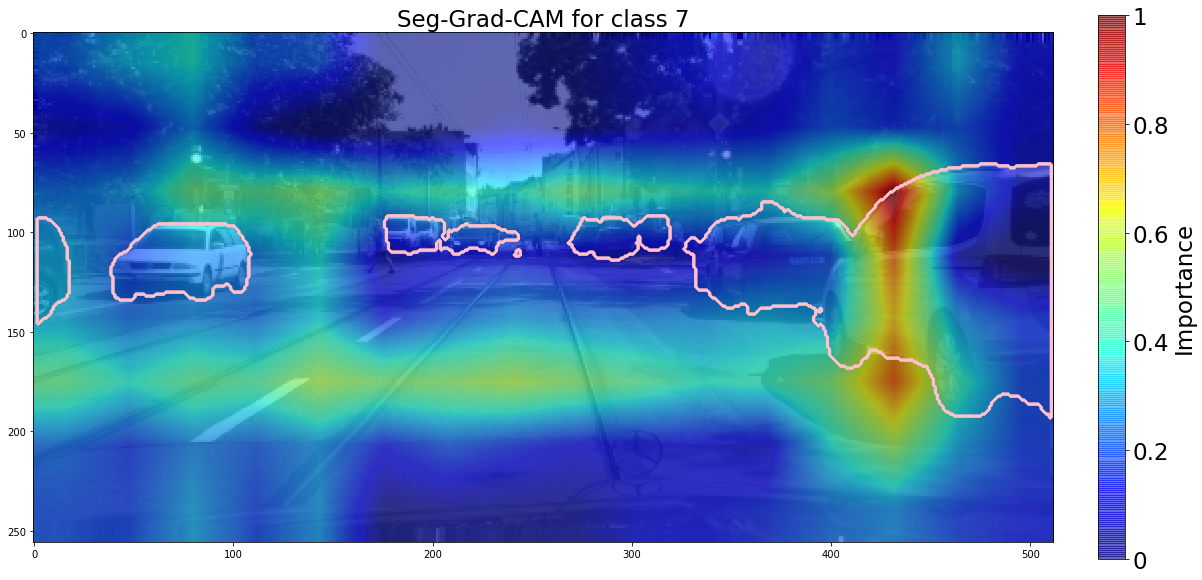

In [29]:

newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainClass()

connectedComponents values, counts:  [0 1 2 3 4 5 6] [112388  14267    831    797    651   2131      7]
argmax:  1
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 14267 14267


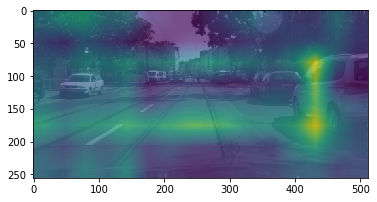

In [27]:
clsroi.largestComponent()
newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainRoi()

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 969 969


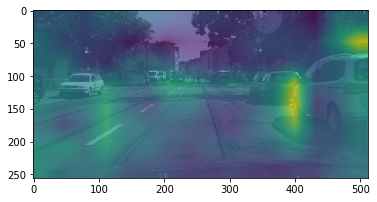

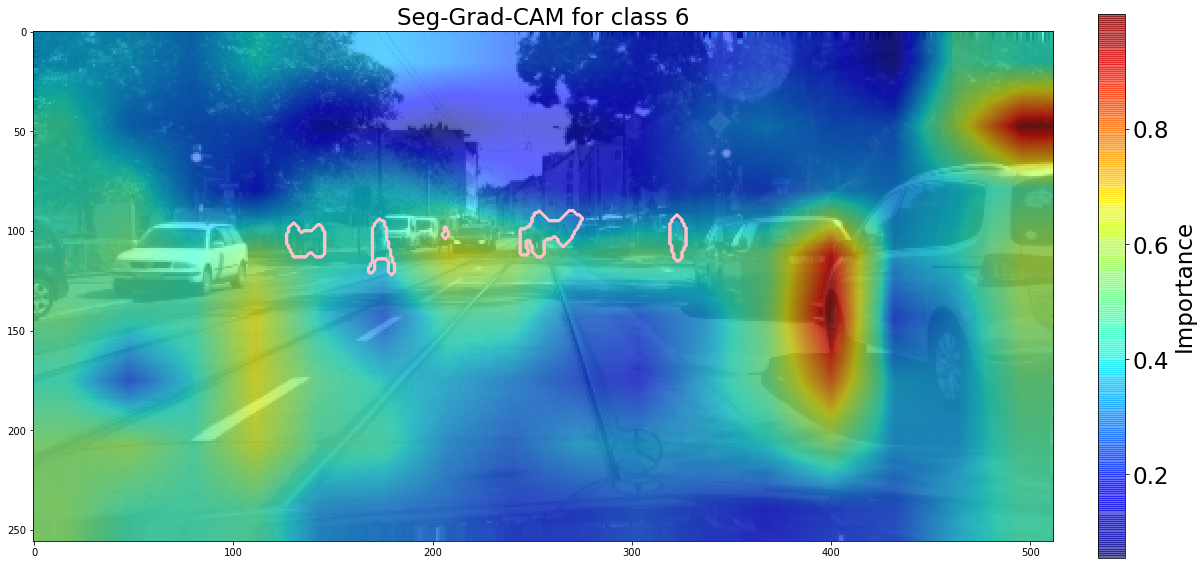

In [33]:
prop_from_layer = model.layers[-1].name
prop_to_layer = 'center_block1_relu'
cls = 6
imid = 3
image =  valset.X[imid]
clsroi = ClassRoI(model=model,image=image,cls=cls)

newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainClass()

connectedComponents values, counts:  [0 1 2 3 4 5] [130103    391    138    178    251     11]
argmin:  5
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 11 11


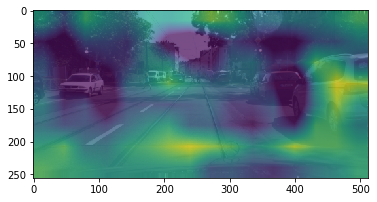

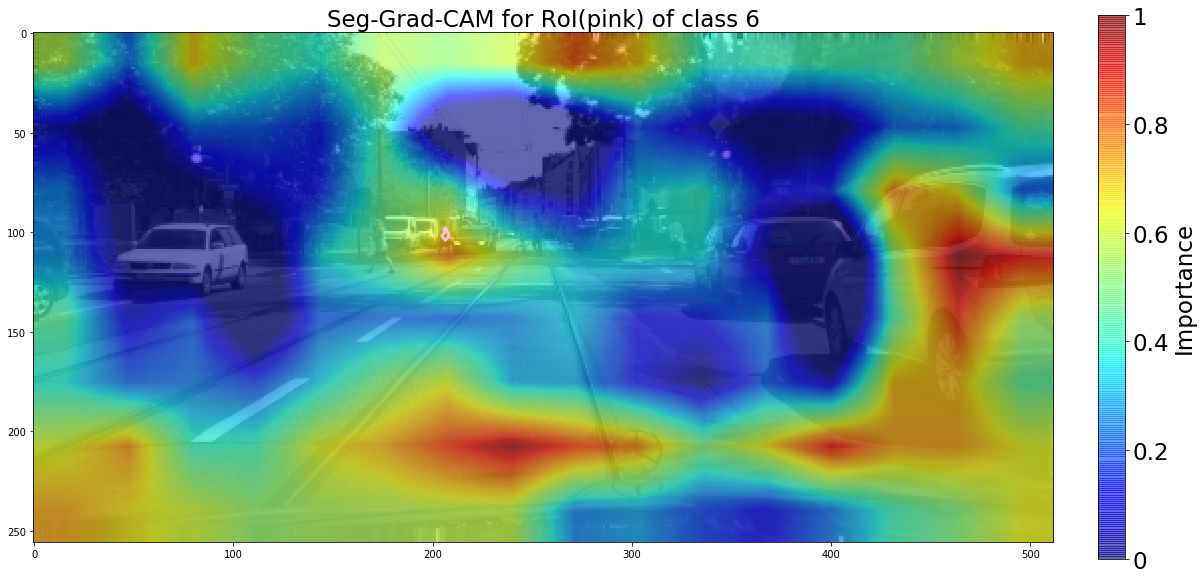

In [34]:
clsroi.smallestComponent()
newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainRoi()

connectedComponents values, counts:  [0 1 2 3 4 5] [130103    391    138    178    251     11]
argmax:  1
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 391 391


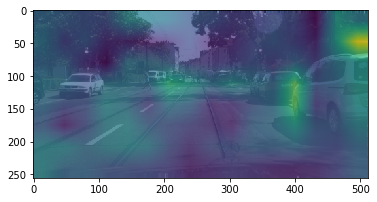

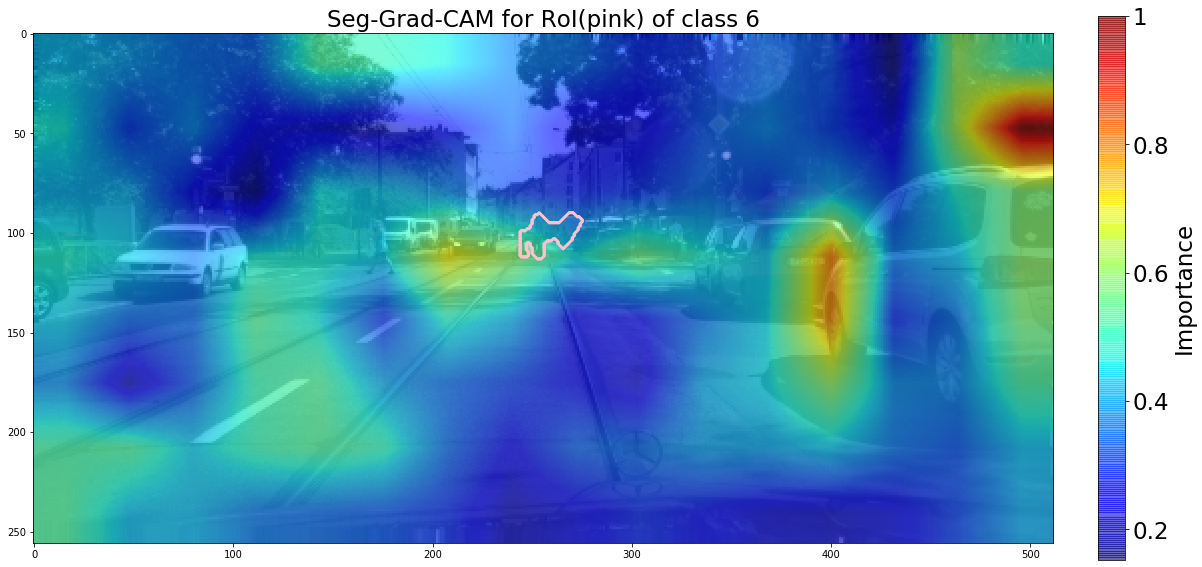

In [35]:
clsroi.largestComponent()
newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainRoi()

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 7071 7071


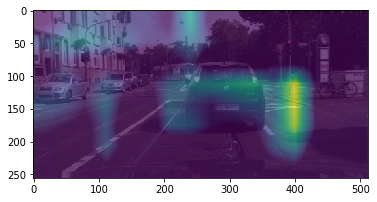

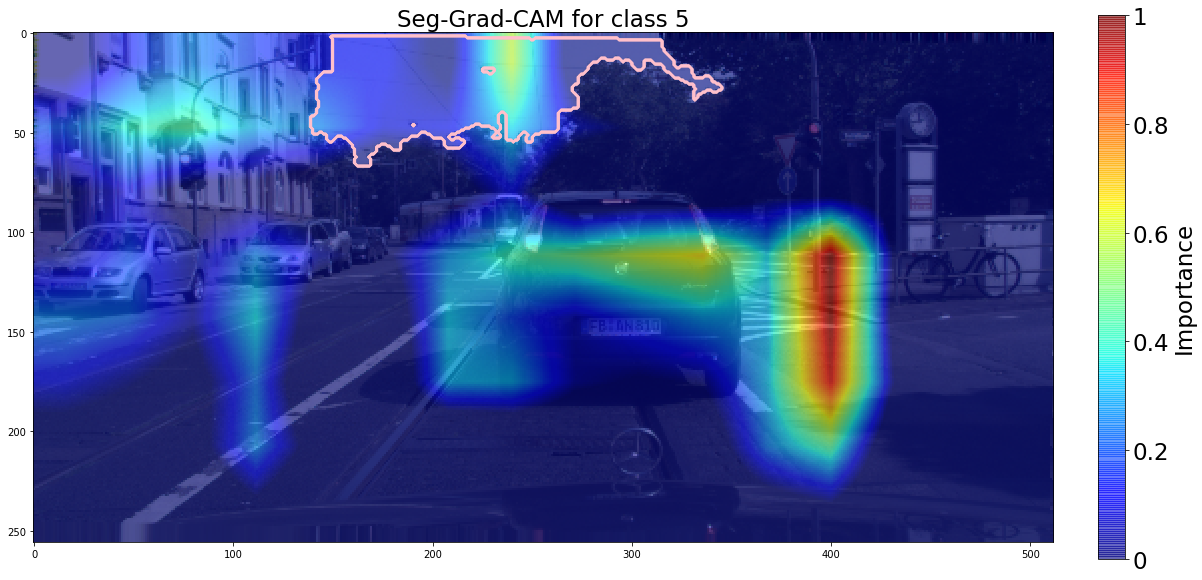

In [57]:
prop_from_layer = model.layers[-1].name
prop_to_layer = 'center_block1_relu'
cls = 5
imid = 8
image =  valset.X[imid]
clsroi = ClassRoI(model=model,image=image,cls=cls)

newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainClass()

connectedComponents values, counts:  [0 1] [124001   7071]
argmax:  1
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 7071 7071


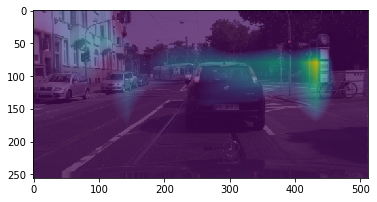

In [56]:
clsroi.largestComponent()
newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainRoi()

connectedComponents values, counts:  [0 1 2 3 4 5 6 7 8] [113009  11432    115    120   1914   3240     10      4   1228]
argmin:  7
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 4 4


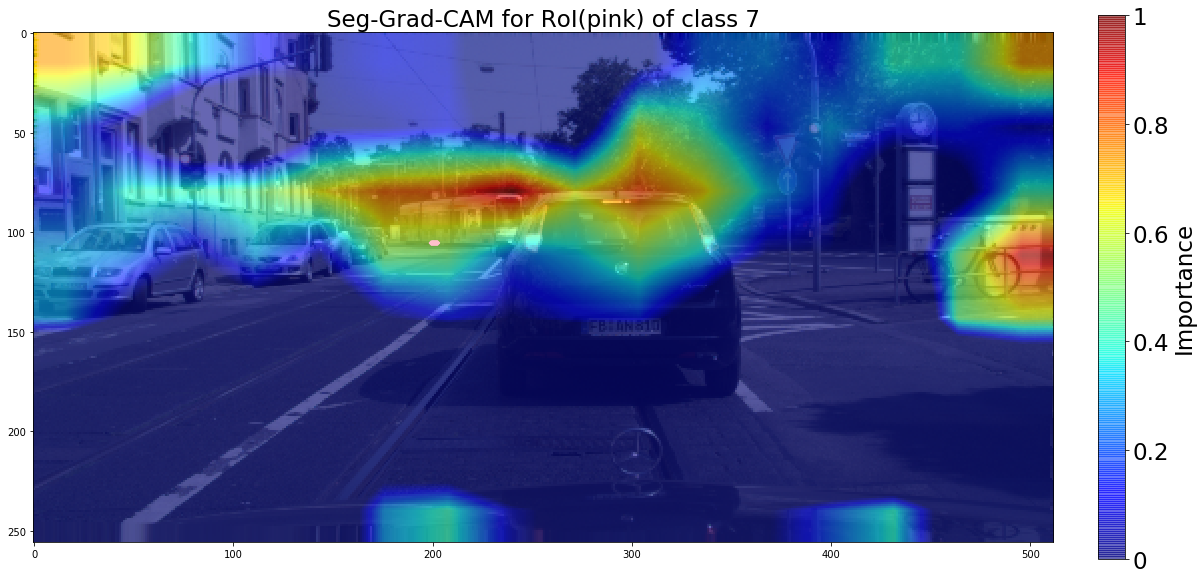

In [52]:
clsroi.smallestComponent()
newsgc = SegGradCAM(model, image, cls, prop_to_layer,  prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
#
newsgc.SGC()
#plt.imshow(
plt.imshow(image)
plt.imshow(newsgc.cam,alpha=0.7)
# create an object with plotting functionality
plotter = SegGradCAMplot(newsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainRoi()